This is the NLL that takes data from all injectors:

<span style="color: red; font-weight: bold;">Nozzle 1-8 + DS300</span> 



In [1]:
from __future__ import annotations

from copy import deepcopy
from pathlib import Path
from datetime import datetime
from typing import Any
import json
import math
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from standarizer import Standardizer


Here we set our working dir.

In [2]:
PROJECT_ROOT = Path.cwd().resolve() 
DATA_DIR = PROJECT_ROOT / "data_penetration"
RUNS_ROOT = PROJECT_ROOT / "runs_mlp"

PROJECT_ROOT

WindowsPath('C:/Users/Jiang/Documents/Mie_Py/Mie_Postprocessing_Py/MLP')

In [3]:
# Loading the saved CSV files
def load_penetration_dataframe(data_dir: Path) -> pd.DataFrame:
    csv_files = sorted(data_dir.glob("*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    frames: list[pd.DataFrame] = []
    for path in csv_files:
        df = pd.read_csv(path)
        df["source_file"] = path.name
        frames.append(df)
    combined = pd.concat(frames, ignore_index=True)
    return combined

Let's try reading the files

In [4]:
raw_df = load_penetration_dataframe(DATA_DIR).dropna().reset_index(drop=True)
print(f"Loaded {len(raw_df)} rows from {raw_df['source_file'].nunique()} files in {DATA_DIR}.")


Loaded 291989 rows from 7 files in C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\MLP\data_penetration.


Let's try seeing its structure

In [5]:
def summarize_numeric(df: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return df[numeric_cols].describe().T[["mean", "std", "min", "max"]]

print(summarize_numeric(raw_df).round(3))

                       mean      std      min      max
penetration_pixels  193.708  102.695    0.000  364.000
is_right_censored     0.144    0.351    0.000    1.000
time_ms               1.188    0.385    0.000    1.960
tilt_angle_radian     0.335    0.077    0.140    0.436
plumes               10.407    0.805   10.000   12.000
diameter_mm           0.366    0.013    0.333    0.384
chamber_pressure     10.523    3.704    5.000   15.000
injection_duration  680.710   93.376  500.000  973.500


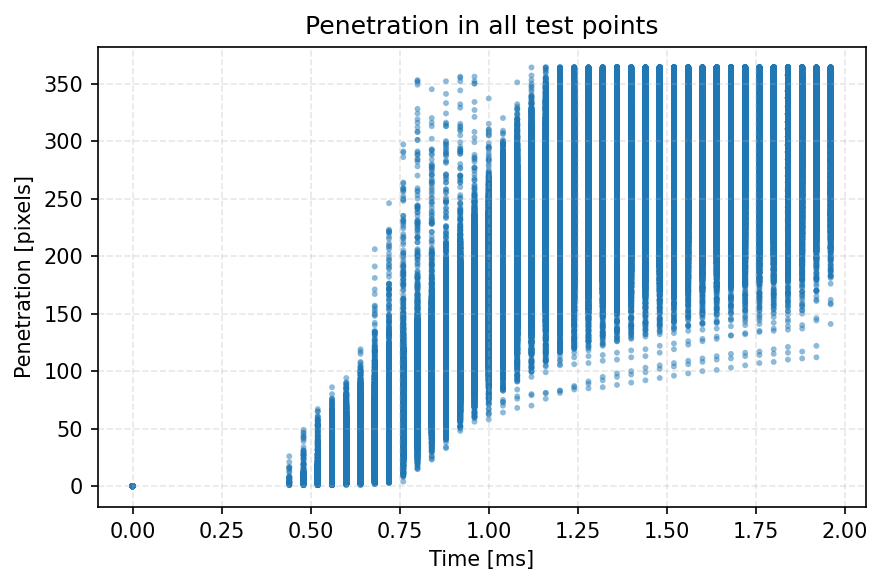

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.scatter(raw_df["time_ms"], raw_df["penetration_pixels"],
s=8, alpha=0.5, edgecolor="none")
ax.set_title("Penetration in all test points")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Penetration [pixels]")
ax.grid(True, linestyle="--", alpha=0.3)
fig.tight_layout()

In [7]:
# Finding all times when penetration pixel <2
times = raw_df.loc[raw_df["penetration_pixels"] < 2, "time_ms"].to_numpy(dtype=float)
times = np.where(times == 0, np.nan, times)
time_shift = np.nanmedian(times)
print(f"time_shift: {time_shift:.2f}s")

df_time_shifted = raw_df.copy()
df_time_shifted.loc[:, "time_ms"] = df_time_shifted["time_ms"] - time_shift # type: ignore 

print(summarize_numeric(df_time_shifted).round(3))

time_shift: 0.52s
                       mean      std      min      max
penetration_pixels  193.708  102.695    0.000  364.000
is_right_censored     0.144    0.351    0.000    1.000
time_ms               0.668    0.385   -0.520    1.440
tilt_angle_radian     0.335    0.077    0.140    0.436
plumes               10.407    0.805   10.000   12.000
diameter_mm           0.366    0.013    0.333    0.384
chamber_pressure     10.523    3.704    5.000   15.000
injection_duration  680.710   93.376  500.000  973.500


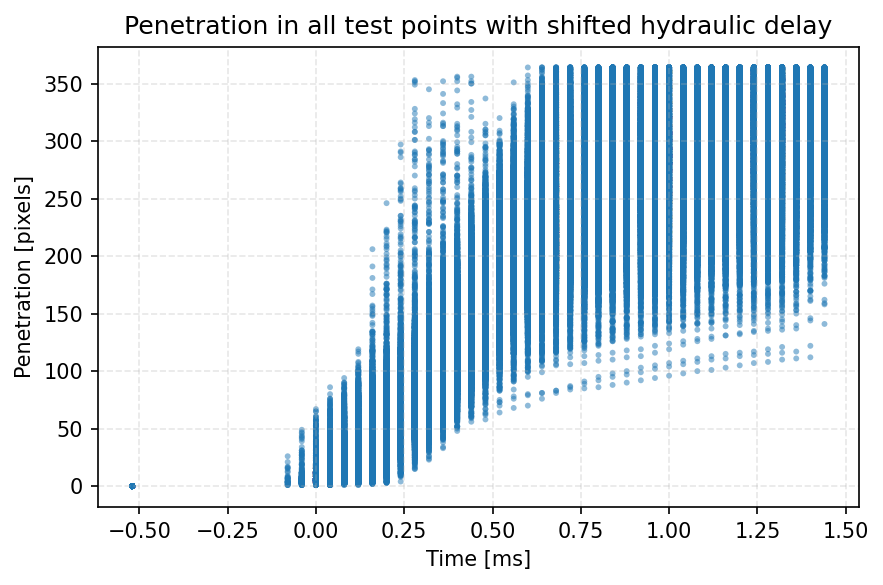

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.scatter(df_time_shifted["time_ms"], df_time_shifted["penetration_pixels"],
s=8, alpha=0.5, edgecolor="none")
ax.set_title("Penetration in all test points with shifted hydraulic delay")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Penetration [pixels]")
ax.grid(True, linestyle="--", alpha=0.3)
fig.tight_layout()

print("")

In [9]:
TARGET_COLUMN = "penetration_pixels"
IGNORED_COLUMNS = {"source_file", "is_right_censored"}
EXPECTED_FEATURE_COLUMNS = [
    "time_ms",
    "tilt_angle_radian",
    "plumes",
    "diameter_mm",
    "chamber_pressure",
    "injection_duration",
]
missing_features = [c for c in EXPECTED_FEATURE_COLUMNS if c not in raw_df.columns]
if missing_features:
    raise ValueError(f"Missing expected feature columns: {missing_features}")
FEATURE_COLUMNS = EXPECTED_FEATURE_COLUMNS
TIME_FEATURE = "time_ms"

print("Feature columns used for training:", FEATURE_COLUMNS)
print("Output features:", TARGET_COLUMN)


Feature columns used for training: ['time_ms', 'tilt_angle_radian', 'plumes', 'diameter_mm', 'chamber_pressure', 'injection_duration']
Output features: penetration_pixels


In [25]:
# Configuration
CONFIG = {
    "seed": 42,
    "data_dir": str(DATA_DIR),
    "target_column": TARGET_COLUMN,
    "feature_columns": FEATURE_COLUMNS,
    "time_feature": TIME_FEATURE,
    "splits": {"val": 0.15, "test": 0.15},
    "batch_size": 512,
    "hidden_dims": [256, 128, 64],
    "dropout": 0.05,
    "activation": "relu",
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "num_workers": 0,
    "pin_memory": torch.cuda.is_available(),
    "shuffle_train": True,
    "epochs": 50,
    "grad_clip_norm": 1.0,
    "log_interval": 50,
    "log_var_bounds": (-10.0, 6.0),
    "std_clamp_min": 1e-3,
    "runs_root": str(RUNS_ROOT.resolve()),
}
CONFIG["use_coordinate_descent"] = False
CONFIG["physics"] = {
    "weight": 5e-3,
    "input_map": {
        "time": "time_ms",
        "delta_p": "chamber_pressure",
        "rho_f": None,
        "rho_a": None,
        "diameter": "diameter_mm",
    },
    "constants": {
        "rho_f": 830.0,
        "rho_a": 1.225,
    },
    "unit_scales": {
        "time": 1e-3,
        "diameter": 1e-3,
    },
    "init_params": {
        "kv": 0.9,
        "kp": 0.6,
        "tau": 0.15,
    },
    "min_tau": 1e-4,
}
CONFIG["hyperparameter_space"] = {
    "lr": [1e-4, 3e-4, 1e-3],
    "weight_decay": [1e-5, 1e-4, 1e-3, 1e-2],
    "epochs": [40, 60, 80],
}
CONFIG["hyperparameter_tolerance"] = 1e-4
CONFIG["input_dim"] = len(CONFIG["feature_columns"])
CONFIG["output_dim"] = 2
CONFIG["device"] = "cuda" if torch.cuda.is_available() else "cpu"
CONFIG["log_epoch_finish"] = True

torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])


In [11]:
# MLP architecture

def make_activation(name: str) -> nn.Module:
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "gelu":
        return nn.GELU()
    if name == "tanh":
        return nn.Tanh()
    raise ValueError(f"Unsupported activation '{name}'")


class PenetrationMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: list[int],
        output_dim: int,
        *,
        activation: str = "relu",
        dropout: float = 0.0,
    ) -> None:
        super().__init__()
        layers: list[nn.Module] = []
        in_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend(
                [
                    nn.Linear(in_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    make_activation(activation),
                ]
            )
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def build_model(config: dict) -> PenetrationMLP:
    return PenetrationMLP(
        input_dim=config["input_dim"],
        hidden_dims=config["hidden_dims"],
        output_dim=config["output_dim"],
        activation=config["activation"],
        dropout=config["dropout"],
    ).to(config["device"])


_model_preview = build_model(CONFIG)
trainable_params = sum(p.numel() for p in _model_preview.parameters() if p.requires_grad)
print(_model_preview)
print(f"Trainable parameters: {trainable_params:,}")
del _model_preview


PenetrationMLP(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (10): ReLU()
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)
Trainable parameters: 43,970


In [12]:
class PenetrationDataset(Dataset):
    def __init__(
        self,
        features: np.ndarray,
        targets: np.ndarray,
        censor_flags: np.ndarray,
        censor_thresholds: np.ndarray,
        physics_features: np.ndarray,
    ) -> None:
        self.features = torch.as_tensor(features, dtype=torch.float32)
        self.targets = torch.as_tensor(targets, dtype=torch.float32)
        self.censor_flags = torch.as_tensor(censor_flags, dtype=torch.float32)
        self.censor_thresholds = torch.as_tensor(censor_thresholds, dtype=torch.float32)
        self.physics_features = torch.as_tensor(physics_features, dtype=torch.float32)

    def __len__(self) -> int:
        return self.features.shape[0]

    def __getitem__(
        self, idx: int
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        return (
            self.features[idx],
            self.targets[idx],
            self.censor_flags[idx],
            self.censor_thresholds[idx],
            self.physics_features[idx],
        )


def build_physics_matrix(
    df: pd.DataFrame,
    physics_cfg: dict,
) -> tuple[np.ndarray, list[str]]:
    input_map: dict[str, str | None] = physics_cfg["input_map"]
    constants: dict[str, float] = physics_cfg.get("constants", {})
    unit_scales: dict[str, float] = physics_cfg.get("unit_scales", {})

    var_order = list(input_map.keys())
    matrix = np.zeros((len(df), len(var_order)), dtype=np.float32)
    for idx, var_name in enumerate(var_order):
        column = input_map[var_name]
        if column is not None:
            if column not in df.columns:
                raise KeyError(f"Physics column '{column}' not found in dataframe.")
            values = df[column].to_numpy(dtype=np.float32, copy=True)
        else:
            if var_name not in constants:
                raise ValueError(
                    f"No column or constant provided for physics variable '{var_name}'."
                )
            values = np.full(len(df), constants[var_name], dtype=np.float32)
        scale = float(unit_scales.get(var_name, 1.0))
        matrix[:, idx] = values * scale
    return matrix, var_order


def unpack_physics_batch(
    tensor: torch.Tensor,
    var_order: list[str],
) -> dict[str, torch.Tensor]:
    return {name: tensor[:, idx : idx + 1] for idx, name in enumerate(var_order)}


Now, we code the data loader and split the data into training, validation and testing datasets.

In [13]:
def train_val_test_split(
    n_samples: int,
    val_ratio: float,
    test_ratio: float,
    *,
    seed: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not 0 < val_ratio < 1 or not 0 < test_ratio < 1:
        raise ValueError("Validation and test ratios must be in (0, 1).")
    if val_ratio + test_ratio >= 1:
        raise ValueError("Sum of validation and test ratios must be < 1.")

    rng = np.random.default_rng(seed)
    indices = np.arange(n_samples)
    rng.shuffle(indices)

    n_test = int(np.floor(test_ratio * n_samples))
    n_val = int(np.floor(val_ratio * n_samples))
    test_idx = indices[:n_test]
    val_idx = indices[n_test : n_test + n_val]
    train_idx = indices[n_test + n_val :]
    return train_idx, val_idx, test_idx


split_cfg = CONFIG["splits"]
train_idx, val_idx, test_idx = train_val_test_split(
    len(raw_df),
    split_cfg["val"],
    split_cfg["test"],
    seed=CONFIG["seed"],
)

feature_array = raw_df[FEATURE_COLUMNS].to_numpy(dtype=np.float32, copy=True)
target_array = raw_df[[TARGET_COLUMN]].to_numpy(dtype=np.float32, copy=True)
censor_array = raw_df[["is_right_censored"]].to_numpy(dtype=np.float32, copy=True)
physics_matrix, physics_var_order = build_physics_matrix(raw_df, CONFIG["physics"])
CONFIG["physics"]["var_order"] = physics_var_order

x_scaler = Standardizer().fit(feature_array[train_idx])
y_scaler = Standardizer().fit(target_array[train_idx])

feature_scaled = x_scaler.transform(feature_array).astype(np.float32, copy=False)
target_scaled = y_scaler.transform(target_array).astype(np.float32, copy=False)

X_train = feature_scaled[train_idx]
X_val = feature_scaled[val_idx]
X_test = feature_scaled[test_idx]

y_train = target_scaled[train_idx]
y_val = target_scaled[val_idx]
y_test = target_scaled[test_idx]

censor_train = censor_array[train_idx]
censor_val = censor_array[val_idx]
censor_test = censor_array[test_idx]
physics_train = physics_matrix[train_idx]
physics_val = physics_matrix[val_idx]
physics_test = physics_matrix[test_idx]

threshold_train = target_scaled[train_idx]
threshold_val = target_scaled[val_idx]
threshold_test = target_scaled[test_idx]

train_dataset = PenetrationDataset(
    X_train,
    y_train,
    censor_train,
    threshold_train,
    physics_train,
)
val_dataset = PenetrationDataset(
    X_val,
    y_val,
    censor_val,
    threshold_val,
    physics_val,
)
test_dataset = PenetrationDataset(
    X_test,
    y_test,
    censor_test,
    threshold_test,
    physics_test,
)


In [14]:
# Checking dataset sizes
print(train_dataset.features.shape)
print(val_dataset.features.shape)
print(test_dataset.features.shape)
print(train_dataset.physics_features.shape)
print("Physics variables:", CONFIG["physics"]["var_order"])


torch.Size([204393, 6])
torch.Size([43798, 6])
torch.Size([43798, 6])
torch.Size([204393, 5])
Physics variables: ['time', 'delta_p', 'rho_f', 'rho_a', 'diameter']


In [15]:
dataloader_kwargs = {
    "batch_size": CONFIG["batch_size"],
    "num_workers": CONFIG["num_workers"],
    "pin_memory": CONFIG["pin_memory"],
}

train_loader = DataLoader(
    train_dataset,
    shuffle=CONFIG["shuffle_train"],
    **dataloader_kwargs,
)
val_loader = DataLoader(val_dataset, shuffle=False, **dataloader_kwargs)
test_loader = DataLoader(test_dataset, shuffle=False, **dataloader_kwargs)

(
    batch_features,
    batch_targets,
    batch_censored,
    batch_thresholds,
    batch_physics,
) = next(iter(train_loader))
print(f"Train batch features shape: {batch_features.shape}")
print(f"Train batch targets shape: {batch_targets.shape}")
print(f"Train batch censor flags shape: {batch_censored.shape}")
print(f"Train batch censor thresholds shape: {batch_thresholds.shape}")
print(f"Train batch physics inputs shape: {batch_physics.shape}")

scalers_state = {"x": x_scaler.state_dict(), "y": y_scaler.state_dict()}
print("Saved scaler keys:", list(scalers_state.keys()))


Train batch features shape: torch.Size([512, 6])
Train batch targets shape: torch.Size([512, 1])
Train batch censor flags shape: torch.Size([512, 1])
Train batch censor thresholds shape: torch.Size([512, 1])
Train batch physics inputs shape: torch.Size([512, 5])
Saved scaler keys: ['x', 'y']


In [16]:
# Constructing the heteroscedastic censored loss + physics prior
LOG_2PI = math.log(2 * math.pi)
SQRT_2 = math.sqrt(2.0)

def gaussian_nll(mu: torch.Tensor, log_var: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    var = log_var.exp().clamp_min(1e-8)
    return 0.5 * ((target - mu) ** 2 / var + log_var + LOG_2PI)


def right_censored_tail_nll(
    mu: torch.Tensor,
    log_var: torch.Tensor,
    threshold: torch.Tensor,
    *,
    std_min: float,
) -> torch.Tensor:
    std = torch.exp(0.5 * log_var).clamp_min(std_min)
    z = (threshold - mu) / std
    tail = 0.5 * torch.erfc(z / SQRT_2)
    return -torch.log(torch.clamp(tail, min=1e-12))


def heteroscedastic_censored_loss(
    mu: torch.Tensor,
    log_var: torch.Tensor,
    target: torch.Tensor,
    threshold: torch.Tensor,
    censor_flags: torch.Tensor,
    *,
    std_min: float,
) -> torch.Tensor:
    censor_mask = censor_flags > 0.5
    base = gaussian_nll(mu, log_var, target)
    censored = right_censored_tail_nll(mu, log_var, threshold, std_min=std_min)
    return torch.where(censor_mask, censored, base)


def split_mu_logvar(output: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    mu, log_var = output.chunk(2, dim=-1)
    return mu, log_var


class SprayPhysics(nn.Module):
    def __init__(
        self,
        *,
        init_params: dict[str, float],
        min_tau: float = 1e-4,
        eps: float = 1e-6,
    ) -> None:
        super().__init__()
        self.log_kv = nn.Parameter(
            torch.log(torch.tensor(init_params.get("kv", 1.0), dtype=torch.float32))
        )
        self.log_kp = nn.Parameter(
            torch.log(torch.tensor(init_params.get("kp", 1.0), dtype=torch.float32))
        )
        self.log_tau = nn.Parameter(
            torch.log(torch.tensor(init_params.get("tau", 0.1), dtype=torch.float32))
        )
        self.min_tau = float(min_tau)
        self.register_buffer("eps", torch.tensor(eps, dtype=torch.float32))

    def forward(self, inputs: dict[str, torch.Tensor]) -> torch.Tensor:
        t = torch.clamp(inputs["time"], min=self.eps)
        delta_p = torch.clamp(inputs.get("delta_p", torch.ones_like(t)), min=self.eps)
        rho_f = torch.clamp(inputs.get("rho_f", torch.ones_like(t)), min=self.eps)
        rho_a = torch.clamp(inputs.get("rho_a", torch.ones_like(t)), min=self.eps)
        diameter = torch.clamp(inputs.get("diameter", torch.ones_like(t)), min=self.eps)

        kv = torch.exp(self.log_kv)
        kp = torch.exp(self.log_kp)
        tau = torch.exp(self.log_tau) + self.min_tau

        linear_segment = kv * torch.sqrt(2.0 * delta_p / rho_f) * t
        sqrt_segment = (
            kp * torch.pow(delta_p / rho_a, 0.25) * torch.sqrt(diameter) * torch.sqrt(t)
        )

        weight = torch.exp(-t / tau)
        return weight * linear_segment + (1.0 - weight) * sqrt_segment

    def export_parameters(self) -> dict[str, float]:
        with torch.no_grad():
            return {
                "kv": float(torch.exp(self.log_kv).detach().cpu()),
                "kp": float(torch.exp(self.log_kp).detach().cpu()),
                "tau": float(torch.exp(self.log_tau).detach().cpu() + self.min_tau),
            }


def build_physics_model(config: dict) -> SprayPhysics:
    physics_cfg = config["physics"]
    return SprayPhysics(
        init_params=physics_cfg["init_params"],
        min_tau=physics_cfg.get("min_tau", 1e-4),
    ).to(config["device"])


In [17]:
def run_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    *,
    optimizer: torch.optim.Optimizer | None,
    y_scaler: Standardizer,
    config: dict,
    physics_model: nn.Module,
    physics_weight: float,
    physics_var_order: list[str],
    target_mu: torch.Tensor,
    target_sigma: torch.Tensor,
) -> dict[str, float]:
    device = config["device"]
    is_train = optimizer is not None
    model.train(mode=is_train)
    physics_model.train(mode=is_train)

    total_loss = 0.0
    data_loss_sum = 0.0
    physics_loss_sum = 0.0
    total_samples = 0
    unc_loss_sum = 0.0
    cens_loss_sum = 0.0
    unc_count = 0
    cens_count = 0
    mae_sum = 0.0
    mse_sum = 0.0
    unc_metric_count = 0

    log_var_min, log_var_max = config["log_var_bounds"]
    std_min = config["std_clamp_min"]
    grad_clip = config.get("grad_clip_norm")

    for batch_idx, batch in enumerate(dataloader, start=1):
        features, targets, censor_flags, thresholds, physics_values = batch
        features = features.to(device)
        targets = targets.to(device)
        censor_flags = censor_flags.to(device)
        thresholds = thresholds.to(device)
        physics_values = physics_values.to(device)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        outputs = model(features)
        mu, log_var_raw = split_mu_logvar(outputs)
        log_var = torch.clamp(log_var_raw, min=log_var_min, max=log_var_max)

        sample_losses = heteroscedastic_censored_loss(
            mu,
            log_var,
            targets,
            thresholds,
            censor_flags,
            std_min=std_min,
        )
        data_loss = sample_losses.mean()

        if physics_weight > 0:
            physics_inputs = unpack_physics_batch(physics_values, physics_var_order)
            physics_penetration = physics_model(physics_inputs)
            phys_scaled = (physics_penetration - target_mu) / target_sigma
            physics_loss = torch.mean((mu - phys_scaled) ** 2)
        else:
            physics_loss = torch.zeros_like(data_loss)

        loss = data_loss + physics_weight * physics_loss

        if is_train:
            loss.backward()
            if grad_clip is not None and grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        batch_size = features.size(0)
        total_samples += batch_size
        total_loss += loss.detach().item() * batch_size
        data_loss_sum += data_loss.detach().item() * batch_size
        physics_loss_sum += physics_loss.detach().item() * batch_size

        with torch.no_grad():
            mu_det = mu.detach()
            log_var_det = log_var.detach()
            targets_det = targets.detach()
            thresholds_det = thresholds.detach()
            censor_mask = (censor_flags > 0.5).detach()

            base_losses = gaussian_nll(mu_det, log_var_det, targets_det).squeeze(-1)
            cens_losses = right_censored_tail_nll(
                mu_det,
                log_var_det,
                thresholds_det,
                std_min=std_min,
            ).squeeze(-1)

            mask_cens = censor_mask.squeeze(-1).to(dtype=torch.bool)
            mask_unc = ~mask_cens

            unc_loss_sum += base_losses[mask_unc].sum().item()
            cens_loss_sum += cens_losses[mask_cens].sum().item()
            unc_count += int(mask_unc.sum().item())
            cens_count += int(mask_cens.sum().item())

            mask_unc_np = mask_unc.cpu().numpy().astype(bool)
            if mask_unc_np.any():
                mu_np = mu_det.cpu().numpy()
                targets_np = targets_det.cpu().numpy()
                mu_raw = y_scaler.inverse_transform(mu_np)
                targets_raw = y_scaler.inverse_transform(targets_np)
                diff = mu_raw[mask_unc_np] - targets_raw[mask_unc_np]
                mae_sum += np.abs(diff).sum()
                mse_sum += np.square(diff).sum()
                unc_metric_count += int(mask_unc_np.sum())

    avg_loss = total_loss / max(total_samples, 1)
    avg_unc_loss = unc_loss_sum / max(unc_count, 1) if unc_count else float("nan")
    avg_cens_loss = cens_loss_sum / max(cens_count, 1) if cens_count else float("nan")
    mae = mae_sum / max(unc_metric_count, 1) if unc_metric_count else float("nan")
    rmse = math.sqrt(mse_sum / max(unc_metric_count, 1)) if unc_metric_count else float("nan")
    avg_data_loss = data_loss_sum / max(total_samples, 1)
    avg_physics_loss = physics_loss_sum / max(total_samples, 1)

    return {
        "loss": avg_loss,
        "data_loss": avg_data_loss,
        "physics_loss": avg_physics_loss,
        "loss_uncensored": avg_unc_loss,
        "loss_censored": avg_cens_loss,
        "mae_raw": mae,
        "rmse_raw": rmse,
        "samples": total_samples,
        "n_uncensored": unc_count,
        "n_censored": cens_count,
    }


In [18]:
def train_single_run(
    *,
    config: dict,
    train_loader: DataLoader,
    val_loader: DataLoader,
    y_scaler: Standardizer,
    target_mu: torch.Tensor,
    target_sigma: torch.Tensor,
    hyperparams: dict[str, float],
    verbose: bool,
    log_epoch_finish: bool,
) -> dict[str, Any]:
    model = build_model(config)
    physics_model = build_physics_model(config)

    params = list(model.parameters()) + list(physics_model.parameters())
    optimizer = torch.optim.AdamW(
        params,
        lr=float(hyperparams["lr"]),
        weight_decay=float(hyperparams["weight_decay"]),
    )

    history: list[dict[str, float]] = []
    best_checkpoint = {
        "epoch": 0,
        "val_loss": float("inf"),
        "model_state": deepcopy(model.state_dict()),
        "physics_state": deepcopy(physics_model.state_dict()),
    }

    epochs = int(hyperparams["epochs"])
    for epoch in range(1, epochs + 1):
        train_metrics = run_epoch(
            model,
            train_loader,
            optimizer=optimizer,
            y_scaler=y_scaler,
            config=config,
            physics_model=physics_model,
            physics_weight=config["physics"]["weight"],
            physics_var_order=config["physics"]["var_order"],
            target_mu=target_mu,
            target_sigma=target_sigma,
        )
        val_metrics = run_epoch(
            model,
            val_loader,
            optimizer=None,
            y_scaler=y_scaler,
            config=config,
            physics_model=physics_model,
            physics_weight=config["physics"]["weight"],
            physics_var_order=config["physics"]["var_order"],
            target_mu=target_mu,
            target_sigma=target_sigma,
        )

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_metrics["loss"],
                "train_data_loss": train_metrics["data_loss"],
                "train_physics_loss": train_metrics["physics_loss"],
                "val_loss": val_metrics["loss"],
                "val_data_loss": val_metrics["data_loss"],
                "val_physics_loss": val_metrics["physics_loss"],
                "val_mae": val_metrics["mae_raw"],
                "val_rmse": val_metrics["rmse_raw"],
            }
        )

        if verbose:
            print(
                f"[lr={hyperparams['lr']:.2e} wd={hyperparams['weight_decay']:.2e}] "
                f"Epoch {epoch:03d} | "
                f"train {train_metrics['loss']:.4f} (data {train_metrics['data_loss']:.4f}, "
                f"phys {train_metrics['physics_loss']:.4f}) | "
                f"val {val_metrics['loss']:.4f} (data {val_metrics['data_loss']:.4f}, "
                f"phys {val_metrics['physics_loss']:.4f}) | "
                f"val MAE {val_metrics['mae_raw']:.4f} | val RMSE {val_metrics['rmse_raw']:.4f}"
            )

        if log_epoch_finish:
            print(
                f"Finished epoch {epoch}/{epochs} "
                f"(lr={hyperparams['lr']:.2e}, wd={hyperparams['weight_decay']:.2e})"
            )

        if val_metrics["loss"] < best_checkpoint["val_loss"]:
            best_checkpoint["epoch"] = epoch
            best_checkpoint["val_loss"] = val_metrics["loss"]
            best_checkpoint["model_state"] = deepcopy(model.state_dict())
            best_checkpoint["physics_state"] = deepcopy(physics_model.state_dict())

    return {
        "history": history,
        "best_checkpoint": best_checkpoint,
    }


def coordinate_descent_search(
    base_hparams: dict[str, float],
    param_space: dict[str, list[float]],
    *,
    config: dict,
    train_loader: DataLoader,
    val_loader: DataLoader,
    y_scaler: Standardizer,
    target_mu: torch.Tensor,
    target_sigma: torch.Tensor,
    tolerance: float,
) -> tuple[dict[str, float], dict[str, Any], dict[tuple[float, float, int], dict[str, Any]]]:
    cache: dict[tuple[float, float, int], dict[str, Any]] = {}

    def key_from(hparams: dict[str, float]) -> tuple[float, float, int]:
        return (
            float(hparams["lr"]),
            float(hparams["weight_decay"]),
            int(hparams["epochs"]),
        )

    def evaluate(hparams: dict[str, float]) -> dict[str, Any]:
        cache_key = key_from(hparams)
        if cache_key not in cache:
            cache[cache_key] = train_single_run(
                config=config,
                train_loader=train_loader,
                val_loader=val_loader,
                y_scaler=y_scaler,
                target_mu=target_mu,
                target_sigma=target_sigma,
                hyperparams=hparams,
                verbose=False,
                log_epoch_finish=False,
            )
        return cache[cache_key]

    best_hparams = dict(base_hparams)
    best_result = evaluate(best_hparams)
    search_order = ["epochs", "lr", "weight_decay"]

    improved = True
    while improved:
        improved = False
        for param_name in search_order:
            values = list(param_space.get(param_name, []))
            if not values:
                continue
            if best_hparams[param_name] not in values:
                values.append(best_hparams[param_name])
            candidates: list[tuple[float, dict[str, float], dict[str, Any]]] = []
            for value in values:
                candidate = dict(best_hparams)
                candidate[param_name] = value
                result = evaluate(candidate)
                val_loss = result["best_checkpoint"]["val_loss"]
                candidates.append((val_loss, candidate, result))
            candidates.sort(key=lambda tup: tup[0])
            top_loss, top_candidate, top_result = candidates[0]
            if top_loss + tolerance < best_result["best_checkpoint"]["val_loss"]:
                best_hparams = top_candidate
                best_result = top_result
                improved = True
            print(f"{param_name}: {top_loss:.4f}")

    return best_hparams, best_result, cache


In [19]:
target_mu_tensor = torch.as_tensor(y_scaler.mu.astype(np.float32)).to(CONFIG["device"])
target_sigma_tensor = torch.as_tensor(y_scaler.sigma.astype(np.float32)).to(
    CONFIG["device"]
)
target_sigma_tensor = torch.clamp(target_sigma_tensor, min=1e-6)

base_hparams = {
    "lr": float(CONFIG["learning_rate"]),
    "weight_decay": float(CONFIG["weight_decay"]),
    "epochs": int(CONFIG["epochs"]),
}

param_space = CONFIG.get("hyperparameter_space", {})
tolerance = float(CONFIG.get("hyperparameter_tolerance", 0.0))
use_coordinate_descent = CONFIG.get("use_coordinate_descent", True)

if param_space and use_coordinate_descent:
    print("Starting coordinate descent hyperparameter search...")
    best_hparams, search_best_result, search_cache = coordinate_descent_search(
        base_hparams,
        param_space,
        config=CONFIG,
        train_loader=train_loader,
        val_loader=val_loader,
        y_scaler=y_scaler,
        target_mu=target_mu_tensor,
        target_sigma=target_sigma_tensor,
        tolerance=tolerance,
    )
    print(
        f"Search evaluated {len(search_cache)} combinations. "
        f"Best val loss: {search_best_result['best_checkpoint']['val_loss']:.4f} "
        f"with hyperparameters {best_hparams}"
    )
else:
    best_hparams = base_hparams
    search_best_result = None
    if param_space and not use_coordinate_descent:
        print("Coordinate descent disabled; using base hyperparameters.")

final_run = train_single_run(
    config=CONFIG,
    train_loader=train_loader,
    val_loader=val_loader,
    y_scaler=y_scaler,
    target_mu=target_mu_tensor,
    target_sigma=target_sigma_tensor,
    hyperparams=best_hparams,
    verbose=True,
    log_epoch_finish=CONFIG.get("log_epoch_finish", False),
)

CONFIG["learning_rate"] = float(best_hparams["lr"])
CONFIG["weight_decay"] = float(best_hparams["weight_decay"])
CONFIG["epochs"] = int(best_hparams["epochs"])

best_checkpoint = final_run["best_checkpoint"]

model = build_model(CONFIG)
model.load_state_dict(best_checkpoint["model_state"])
physics_model = build_physics_model(CONFIG)
physics_model.load_state_dict(best_checkpoint["physics_state"])

print(
    f"Loaded best model from epoch {best_checkpoint['epoch']} "
    f"with validation loss {best_checkpoint['val_loss']:.4f}."
)

test_metrics = run_epoch(
    model,
    test_loader,
    optimizer=None,
    y_scaler=y_scaler,
    config=CONFIG,
    physics_model=physics_model,
    physics_weight=CONFIG["physics"]["weight"],
    physics_var_order=CONFIG["physics"]["var_order"],
    target_mu=target_mu_tensor,
    target_sigma=target_sigma_tensor,
)

print(
    "Test metrics | "
    f"loss {test_metrics['loss']:.4f} | "
    f"MAE {test_metrics['mae_raw']:.4f} | "
    f"RMSE {test_metrics['rmse_raw']:.4f} | "
    f"uncensored samples {test_metrics['n_uncensored']} | "
    f"censored samples {test_metrics['n_censored']} | "
    f"physics loss {test_metrics['physics_loss']:.4f}"
)

history = final_run["history"]
history_df = pd.DataFrame(history)
history_df.tail()


Coordinate descent disabled; using base hyperparameters.
[lr=1.00e-03 wd=1.00e-04] Epoch 001 | train 0.1122 (data 0.0871, phys 5.0128) | val -0.0956 (data -0.1228, phys 5.4235) | val MAE 18.1464 | val RMSE 24.8023
Finished epoch 1/50 (lr=1.00e-03, wd=1.00e-04)
[lr=1.00e-03 wd=1.00e-04] Epoch 002 | train -0.0268 (data -0.0527, phys 5.1660) | val -0.1482 (data -0.1750, phys 5.3632) | val MAE 17.3844 | val RMSE 23.9023
Finished epoch 2/50 (lr=1.00e-03, wd=1.00e-04)
[lr=1.00e-03 wd=1.00e-04] Epoch 003 | train -0.0609 (data -0.0869, phys 5.2035) | val -0.1605 (data -0.1872, phys 5.3482) | val MAE 16.7747 | val RMSE 22.6713
Finished epoch 3/50 (lr=1.00e-03, wd=1.00e-04)
[lr=1.00e-03 wd=1.00e-04] Epoch 004 | train -0.0786 (data -0.1049, phys 5.2563) | val -0.1627 (data -0.1887, phys 5.2030) | val MAE 16.7099 | val RMSE 22.3529
Finished epoch 4/50 (lr=1.00e-03, wd=1.00e-04)
[lr=1.00e-03 wd=1.00e-04] Epoch 005 | train -0.0919 (data -0.1183, phys 5.2790) | val -0.1445 (data -0.1715, phys 5.4111)

,epoch,train_loss,train_data_loss,train_physics_loss,val_loss,val_data_loss,val_physics_loss,val_mae,val_rmse
45,46,-0.192787,-0.197264,0.895290,-0.254439,-0.258905,0.893181,16.181931,21.957781
46,47,-0.194316,-0.198785,0.893679,-0.250872,-0.255555,0.936512,16.183274,21.919028
47,48,-0.194751,-0.199176,0.884978,-0.250983,-0.255612,0.925758,16.217883,22.019939
48,49,-0.194485,-0.198891,0.881218,-0.250487,-0.254830,0.868601,16.254630,22.066976
49,50,-0.195893,-0.200323,0.886144,-0.253683,-0.257878,0.839126,16.146782,21.878726


In [20]:
runs_root_path = Path(CONFIG["runs_root"])
runs_root_path.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"penetration_hetero_{timestamp}"
run_dir = runs_root_path / run_name
run_dir.mkdir(parents=True, exist_ok=False)

torch.save(best_checkpoint["model_state"], run_dir / "best_model.pt")
torch.save(best_checkpoint["physics_state"], run_dir / "best_physics.pt")
with open(run_dir / "scalers.json", "w", encoding="utf-8") as f:
    json.dump(scalers_state, f, indent=2)


def _to_serializable(value):
    if isinstance(value, (np.floating, np.integer)):
        return value.item()
    if isinstance(value, float):
        return None if math.isnan(value) else float(value)
    if isinstance(value, (list, tuple)):
        return [_to_serializable(v) for v in value]
    if isinstance(value, dict):
        return {k: _to_serializable(v) for k, v in value.items()}
    return value


train_config_export = _to_serializable({k: v for k, v in CONFIG.items()})
test_metrics_export = _to_serializable(test_metrics)
best_history_entry = min(history, key=lambda d: d["val_loss"]) if history else None
metadata = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "run_name": run_name,
    "best_epoch": int(best_checkpoint["epoch"]),
    "best_val_loss": float(best_checkpoint["val_loss"]),
    "train_rows": int(len(train_dataset)),
    "val_rows": int(len(val_dataset)),
    "test_rows": int(len(test_dataset)),
    "history_best": _to_serializable(best_history_entry) if best_history_entry else None,
    "test_metrics": test_metrics_export,
    "best_hyperparams": {
        "lr": float(CONFIG["learning_rate"]),
        "weight_decay": float(CONFIG["weight_decay"]),
        "epochs": int(CONFIG["epochs"]),
    },
}
physics_param_export = physics_model.export_parameters()
with open(run_dir / "model_config.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": {
                "input_dim": CONFIG["input_dim"],
                "output_dim": CONFIG["output_dim"],
                "hidden_dims": CONFIG["hidden_dims"],
                "activation": CONFIG["activation"],
                "dropout": CONFIG["dropout"],
            },
            "data": {
                "feature_columns": CONFIG["feature_columns"],
                "time_feature": CONFIG["time_feature"],
                "target_column": CONFIG["target_column"],
                "std_clamp_min": CONFIG["std_clamp_min"],
            },
            "physics": {
                "weight": CONFIG["physics"]["weight"],
                "input_map": CONFIG["physics"]["input_map"],
                "constants": CONFIG["physics"].get("constants", {}),
                "unit_scales": CONFIG["physics"].get("unit_scales", {}),
                "init_params": CONFIG["physics"]["init_params"],
                "learned_params": physics_param_export,
            },
            "training": train_config_export,
            "metadata": metadata,
        },
        f,
        indent=2,
    )
history_df.to_csv(run_dir / "history.csv", index=False)
with open(run_dir / "summary.txt", "w", encoding="utf-8") as f:
    f.write(f"Run directory: {run_dir}")
    f.write(f"Best epoch: {best_checkpoint['epoch']}")
    f.write(f"Validation loss: {best_checkpoint['val_loss']:.4f}")
    f.write(f"Best hyperparameters: {metadata['best_hyperparams']}")
    f.write(f"Physics parameters: {physics_param_export}")
    f.write(f"Test metrics: {test_metrics_export}")

print(f"Saved run artifacts to {run_dir}")


Saved run artifacts to C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\MLP\runs_mlp\penetration_hetero_20251212_110530


In [21]:
model.eval()

PenetrationMLP(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (10): ReLU()
    (11): Dropout(p=0.05, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [ ]:
# Saving to ONNX
dummy = torch.randn(1, 6).to(CONFIG["device"])

torch.onnx.export(
    model, dummy, run_dir /"best_model.onnx",
    opset_version=17,
    input_names=["working conditions"] ,
    output_names=["penetration mean & std"],
    dynamic_axes={"working conditions" :{0:"batch"}, "pred" : {0: "batch"}}
)

In [ ]:
print("x_mu:", x_scaler.mu.flatten())
print("x_sigma:", x_scaler.sigma.flatten())
print("y_mu:", y_scaler.mu.flatten())
print("y_sigma:", y_scaler.sigma.flatten())

x_mu: [1.1881047e+00 3.3441335e-01 1.0406022e+01 3.6607635e-01 1.0517851e+01
 6.8071155e+02]
x_sigma: [3.84559512e-01 7.69684613e-02 8.04028273e-01 1.32039115e-02
 3.70296621e+00 9.33746414e+01]
y_mu: [193.669]
y_sigma: [102.68874]


: 